In [1]:
import ccxt
import time
import logging
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta, datetime
from utils import from_exchange_to_standard_notation, from_standard_to_exchange_notation
from scipy import stats

In [2]:
data1 = pd.read_csv('tradedata/20190723.csv.gz')
data2 = pd.read_csv('tradedata/20190724.csv.gz')
data3 = pd.read_csv('tradedata/20190725.csv.gz')
data4 = pd.read_csv('tradedata/20190726.csv.gz')

data = data1
data = data.append(data2)
data = data.append(data3)
data = data.append(data4)

btc_data = data[data.symbol == 'XBTUSD']
btc_data['time'] = btc_data.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))
btc_data.set_index('time', inplace=True)
btc_data.head()

/Users/davidvanisacker/backtest/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,time
181756,2019-07-23D00:00:03.083772000,XBTUSD,Sell,1,10320.0,MinusTick,2ceb93f2-f0cb-8e7d-979b-14e8332107b7,9690,0.000097,1.0,2019-07-23 00:00:03.083772
181757,2019-07-23D00:00:03.606674000,XBTUSD,Buy,1293,10320.5,PlusTick,3685e334-9682-07a2-76f7-b482bdbc3a37,12527877,0.125279,1293.0,2019-07-23 00:00:03.606674
181758,2019-07-23D00:00:03.606674000,XBTUSD,Buy,2062,10320.5,ZeroPlusTick,07ed8590-0630-b435-fae6-5a985097353b,19978718,0.199787,2062.0,2019-07-23 00:00:03.606674
181759,2019-07-23D00:00:03.606674000,XBTUSD,Buy,1645,10320.5,ZeroPlusTick,7068ae6e-8f6c-c466-5f23-d3a481258384,15938405,0.159384,1645.0,2019-07-23 00:00:03.606674
181760,2019-07-23D00:00:03.773994000,XBTUSD,Buy,3355,10320.5,ZeroPlusTick,0ac37b58-3cd7-887e-51e0-b1976d7af90e,32506595,0.325066,3355.0,2019-07-23 00:00:03.773994


In [3]:
# def compute_vwap(df):
#     q = df['foreignNotional']
#     p = df['price']
#     vwap = np.sum(p * q) / np.sum(q)
#     df['vwap'] = vwap
#     return df

# data_timeidx = btc_data.set_index('time')
# data_time_grp = data_timeidx.groupby(pd.Grouper(freq='15Min'))
# num_time_bars = len(data_time_grp) # comes in handy later
# data_time_vwap = data_time_grp.apply(compute_vwap)

In [4]:
# total_ticks = len(btc_data)
# num_ticks_per_bar = total_ticks / num_time_bars
# num_ticks_per_bar = round(num_ticks_per_bar, -3) #round to nearest 1000
# data_tick_grp = btc_data.reset_index().assign(grpId=lambda row: row.index // num_ticks_per_bar)
# data_tick_vwap = data_tick_grp.groupby('grpId').apply(compute_vwap)
# data_tick_vwap.set_index('time', inplace=True)

In [5]:
# data_cm_vol = btc_data.assign(cmVol=btc_data['homeNotional'].cumsum()) 
# total_vol = data_cm_vol.cmVol.values[-1]
# vol_per_bar = total_vol / num_time_bars
# vol_per_bar = round(vol_per_bar, -2) # round to the nearest hundred
# data_vol_grp = data_cm_vol.assign(grpId=lambda row: row.cmVol // vol_per_bar)
# data_vol_vwap =  data_vol_grp.groupby('grpId').apply(compute_vwap)
# data_vol_vwap.set_index('time', inplace=True)

In [6]:
# data_cm_vol = btc_data.assign(cmVol=btc_data['foreignNotional'].cumsum()) 
# total_vol = data_cm_vol.cmVol.values[-1]
# vol_per_bar = total_vol / num_time_bars
# vol_per_bar = round(vol_per_bar, -2) # round to the nearest hundred
# data_vol_grp = data_cm_vol.assign(grpId=lambda row: row.cmVol // vol_per_bar)
# data_vol_vwap =  data_vol_grp.groupby('grpId').apply(compute_vwap)
# data_vol_vwap.set_index('time', inplace=True)

In [24]:
class BarSeries(object):
    '''
        Base class for resampling ticks dataframe into OHLC(V)
        using different schemes. This particular class implements
        standard time bars scheme.
        See: https://www.wiley.com/en-it/Advances+in+Financial+Machine+Learning-p-9781119482086
    '''
    
    def __init__(self, df, datetimecolumn = 'time'):
        self.df = df
        self.datetimecolumn = datetimecolumn
    
    def process_column(self, column_name, frequency):
        return self.df[column_name].resample(frequency, label='right').ohlc()
    
    def process_volume(self, column_name, frequency):
        return self.df[column_name].resample(frequency, label='right').sum()
    
    def process_ticks(self, price_column = 'price', volume_column = 'size', frequency = '5T'):
        price_df = self.process_column(price_column, frequency)
        volume_df = self.process_volume(volume_column, frequency)
        price_df['volume'] = volume_df
        return price_df
    

class TickBarSeries(BarSeries):
    '''
        Class for generating tick bars based on bid-ask-size dataframe
    '''
    def __init__(self, df, datetimecolumn = 'time', volume_column = 'size'):
        self.volume_column = volume_column
        super(TickBarSeries, self).__init__(df, datetimecolumn)
    
    def process_column(self, column_name, frequency):
        res = []
        for i in range(frequency, len(self.df), frequency):
            sample = self.df.iloc[i-frequency:i]
            v = sample[self.volume_column].values.sum()
            o = sample[column_name].values.tolist()[0]
            h = sample[column_name].values.max()
            l = sample[column_name].values.min()
            c = sample[column_name].values.tolist()[-1]
            d = sample.index.values[-1]
            
            res.append({
                self.datetimecolumn: d,
                'open': o,
                'high': h,
                'low': l,
                'close': c,
                'volume': v
            })

        res = pd.DataFrame(res).set_index(self.datetimecolumn)
        return res

    
    def process_ticks(self, price_column = 'price', volume_column = 'size', frequency = '15Min'):
        price_df = self.process_column(price_column, frequency)
        return price_df    
    

class VolumeBarSeries(BarSeries):
    '''
        Class for generating volume bars based on bid-ask-size dataframe
    '''
    def __init__(self, df, datetimecolumn = 'time', volume_column = 'size'):
        self.volume_column = volume_column
        super(VolumeBarSeries, self).__init__(df, datetimecolumn)
               
    def process_column(self, column_name, frequency):
        res = []
        buf = []
        start_index = 0.
        volume_buf = 0.
        for i in range(len(self.df[column_name])):

            pi = self.df[column_name].iloc[i]
            vi = self.df[self.volume_column].iloc[i]
            di = self.df.index.values[i]
            
            buf.append(pi)
            volume_buf += vi
            
            if volume_buf >= frequency:
                
                o = buf[0]
                h = np.max(buf)
                l = np.min(buf)
                c = buf[-1]
                
                res.append({
                    self.datetimecolumn: di,
                    'open': o,
                    'high': h,
                    'low': l,
                    'close': c,  
                    'volume': volume_buf
                })
                
                buf, volume_buf = [], 0.

        res = pd.DataFrame(res).set_index(self.datetimecolumn)
        return res
    
    def process_ticks(self, price_column = 'price', volume_column = 'size', frequency = 10000):
        price_df = self.process_column(price_column, frequency)
        return price_df    
    

class DollarBarSeries(BarSeries):
    '''
        Class for generating "dollar" bars based on bid-ask-size dataframe
    '''
    def __init__(self, df, datetimecolumn = 'time', volume_column = 'size'):
        self.volume_column = volume_column
        super(DollarBarSeries, self).__init__(df, datetimecolumn)
               
    def process_column(self, column_name, frequency):
        res = []
        buf, vbuf = [], []
        start_index = 0.
        dollar_buf = 0.
        for i in range(len(self.df[column_name])):

            pi = self.df[column_name].iloc[i]
            vi = self.df[self.volume_column].iloc[i]
            di = self.df.index.values[i]
            dvi = self.df['foreignNotional'].iloc[i]
            buf.append(pi)
            vbuf.append(vi)
            dollar_buf += dvi
            
            if dollar_buf >= frequency:
                
                o = buf[0]
                h = np.max(buf)
                l = np.min(buf)
                c = buf[-1]
                v = np.sum(vbuf)
                
                res.append({
                    self.datetimecolumn: di,
                    'open': o,
                    'high': h,
                    'low': l,
                    'close': c,
                    'volume': v,
                    'dollar': dollar_buf
                })
                
                buf, vbuf, dollar_buf = [], [], 0.

        res = pd.DataFrame(res).set_index(self.datetimecolumn)
        return res 
    
    def process_ticks(self, price_column = 'price', volume_column = 'size', frequency = 10000):
        price_df = self.process_column(price_column, frequency)
        return price_df
    
    
    
class BitcoinBarSeries(BarSeries):
    '''
        Class for generating "dollar" bars based on bid-ask-size dataframe
    '''
    def __init__(self, df, datetimecolumn = 'time', volume_column = 'size'):
        self.volume_column = volume_column
        super(BitcoinBarSeries, self).__init__(df, datetimecolumn)
               
    def process_column(self, column_name, frequency):
        res = []
        buf, vbuf = [], []
        start_index = 0.
        dollar_buf = 0.
        for i in range(len(self.df[column_name])):

            pi = self.df[column_name].iloc[i]
            vi = self.df[self.volume_column].iloc[i]
            di = self.df.index.values[i]
            dvi = self.df['homeNotional'].iloc[i]
            buf.append(pi)
            vbuf.append(vi)
            dollar_buf += dvi
            
            if dollar_buf >= frequency:
                
                o = buf[0]
                h = np.max(buf)
                l = np.min(buf)
                c = buf[-1]
                v = np.sum(vbuf)
                
                res.append({
                    self.datetimecolumn: di,
                    'open': o,
                    'high': h,
                    'low': l,
                    'close': c,
                    'volume': v,
                    'dollar': dollar_buf
                })
                
                buf, vbuf, dollar_buf = [], [], 0.

        res = pd.DataFrame(res).set_index(self.datetimecolumn)
        return res 
    
    def process_ticks(self, price_column = 'price', volume_column = 'size', frequency = 10000):
        price_df = self.process_column(price_column, frequency)
        return price_df

In [65]:
time_bars = BarSeries(btc_data).process_ticks(frequency='1min')
num_timebars = time_bars.shape[0]
print(num_timebars)

5760


In [66]:
volume_bars = VolumeBarSeries(btc_data).process_ticks(frequency=2000000)

In [67]:
bitcoin_bars = BitcoinBarSeries(btc_data).process_ticks(frequency=200)

In [68]:
tick_bars = TickBarSeries(btc_data).process_ticks(frequency=500)

In [69]:
num_time_bars = time_bars.shape[0]
num_volume_bars = volume_bars.shape[0]
num_bitcoin_bars = bitcoin_bars.shape[0]
num_tick_bars = tick_bars.shape[0]

print(num_time_bars)
print(num_volume_bars)
print(num_bitcoin_bars)
print(num_tick_bars)

5760
5571
5642
6124


In [70]:
# Number of bars for normal 5 min candlesticks (for 4 days data)
number_1_min_candles = 24 * 60 * 4 
number_5_min_candles = 24 * 60 * 4 / 5
number_15_min_candles = 24 * 60 * 4 / 15
number_1h_candles = 24 * 4

number_trades = btc_data.shape[0]

/Users/davidvanisacker/backtest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


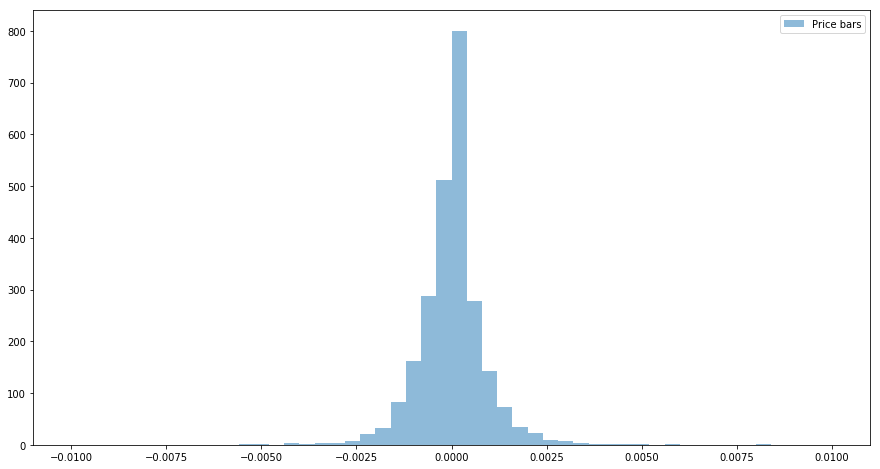

In [71]:
plt.figure(figsize = (15, 8))
plt.hist(time_bars.close.pct_change().dropna().values.tolist(), label = 'Price bars', alpha = 0.5, normed=True, bins=50, range = (-0.01, 0.01))
plt.legend()
plt.show()

/Users/davidvanisacker/backtest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


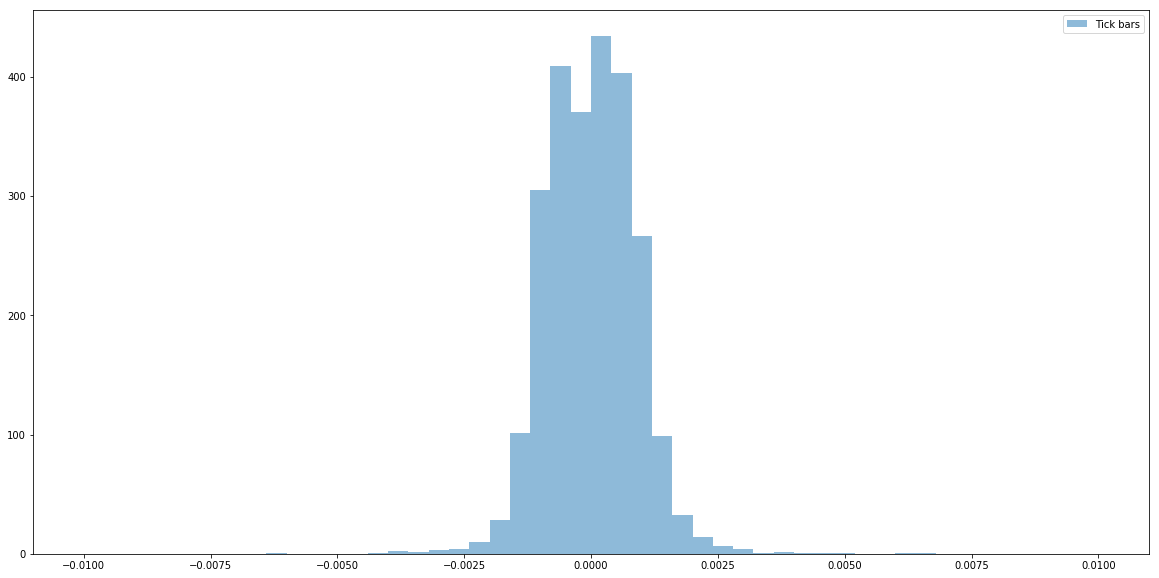

In [72]:
plt.figure(figsize = (20, 10))
plt.hist(tick_bars.close.pct_change().dropna().values.tolist(), label = 'Tick bars', alpha = 0.5, normed=True, bins=50, range = (-0.01, 0.01))
plt.legend()
plt.show()

/Users/davidvanisacker/backtest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


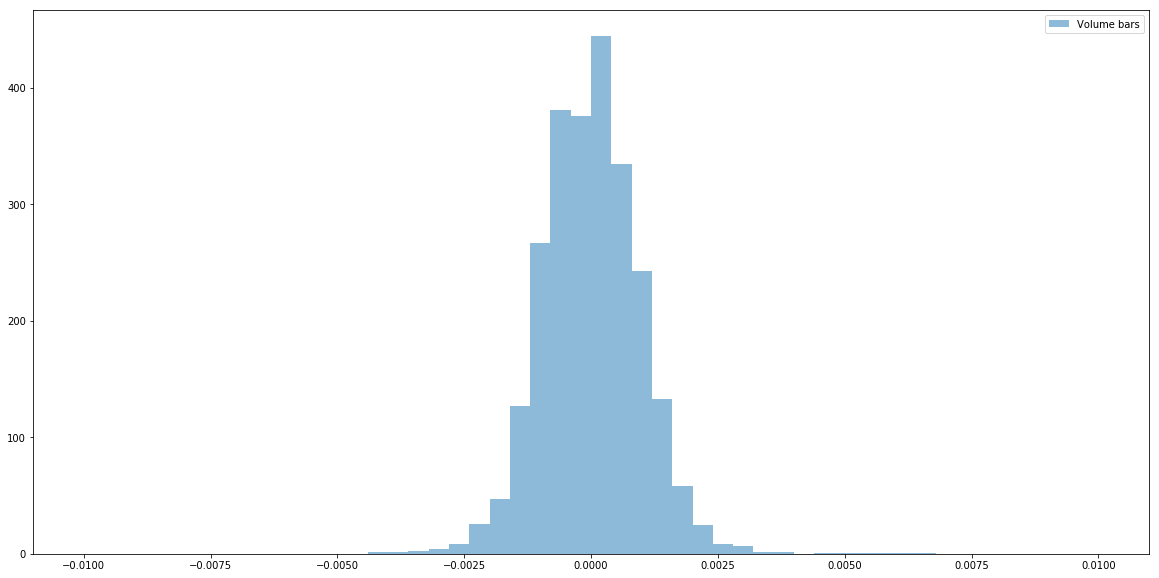

In [73]:
plt.figure(figsize = (20, 10))
plt.hist(volume_bars.close.pct_change().dropna().values.tolist(), label = 'Volume bars', alpha = 0.5, normed=True, bins=50, range = (-0.01, 0.01))
plt.legend()
plt.show()

/Users/davidvanisacker/backtest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


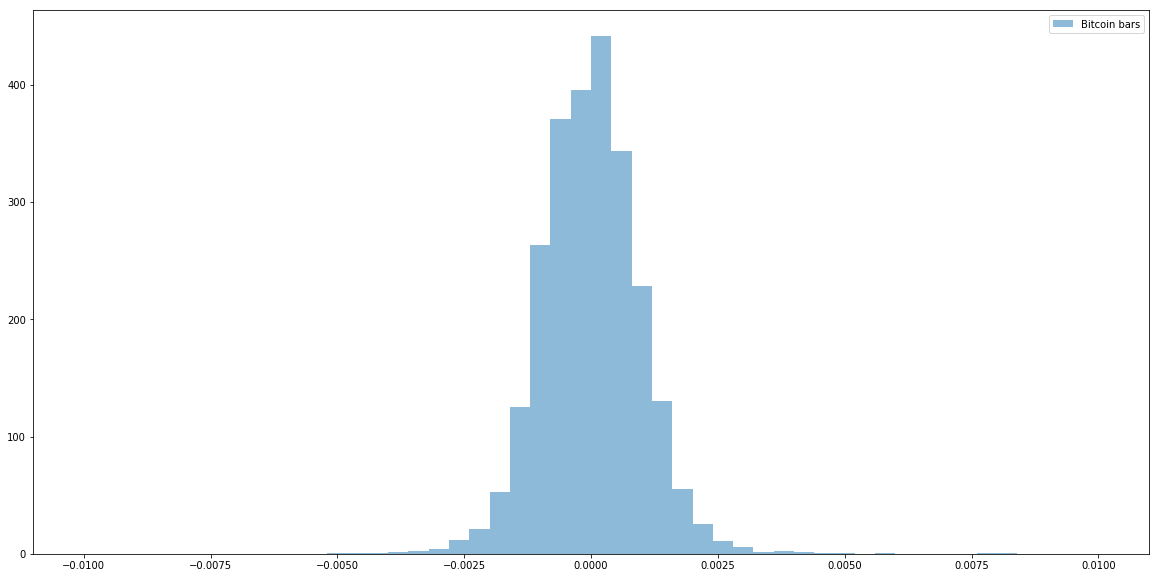

In [74]:
plt.figure(figsize = (20, 10))
plt.hist(bitcoin_bars.close.pct_change().dropna().values.tolist(), label = 'Bitcoin bars', alpha = 0.5, normed=True, bins=50, range = (-0.01, 0.01))
plt.legend()
plt.show()

/Users/davidvanisacker/backtest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/davidvanisacker/backtest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/davidvanisacker/backtest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/davidvanisacker/backtest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.

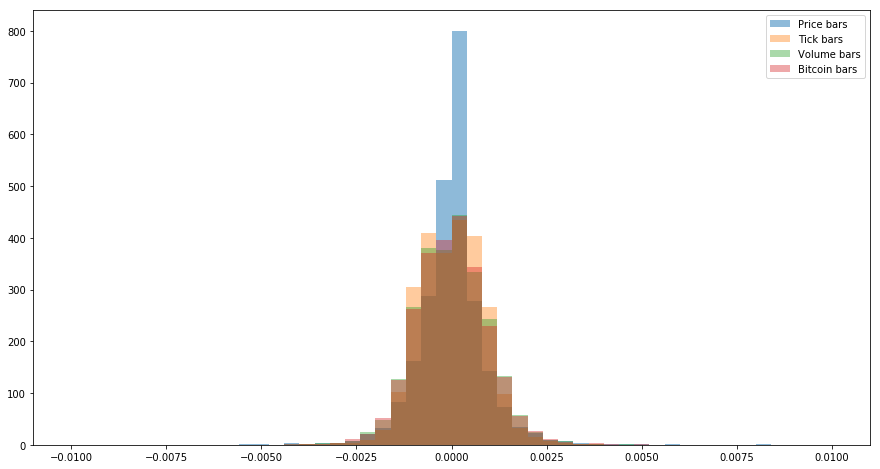

In [75]:
plt.figure(figsize = (15, 8))
plt.hist(time_bars.close.pct_change().dropna().values.tolist(), label = 'Price bars', alpha = 0.5, normed=True, bins=50, range = (-0.01, 0.01))
plt.hist(tick_bars.close.pct_change().dropna().values.tolist(), label = 'Tick bars', alpha = 0.4, normed=True, bins=50, range = (-0.01, 0.01))
plt.hist(volume_bars.close.pct_change().dropna().values.tolist(), label = 'Volume bars', alpha = 0.4, normed=True, bins=50, range = (-0.01, 0.01))
plt.hist(bitcoin_bars.close.pct_change().dropna().values.tolist(), label = 'Bitcoin bars', alpha = 0.4, normed=True, bins=50, range = (-0.01, 0.01))
plt.legend()
plt.show()

In [76]:
print(pd.Series.autocorr(time_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(tick_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(volume_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(bitcoin_bars.close.pct_change().dropna()))

print('-' * 20)
print('-' * 20)

print(np.var(time_bars.close.pct_change().dropna()))
print(np.var(tick_bars.close.pct_change().dropna()))
print(np.var(volume_bars.close.pct_change().dropna()))
print(np.var(bitcoin_bars.close.pct_change().dropna()))

-0.018038688650118748
0.10539562881593305
0.06200395623604091
0.032151297998283736
--------------------
--------------------
1.0283051719092947e-06
7.4031385348209e-07
9.15688249361474e-07
9.322493657110546e-07


In [77]:
print(stats.jarque_bera(time_bars.close.pct_change().dropna()))
print(stats.jarque_bera(tick_bars.close.pct_change().dropna()))
print(stats.jarque_bera(volume_bars.close.pct_change().dropna()))
print(stats.jarque_bera(bitcoin_bars.close.pct_change().dropna()))

(519776.0218091941, 0.0)
(1420.2595752314219, 0.0)
(926.7082610940913, 0.0)
(2346.5105129427247, 0.0)


In [78]:
print(tick_bars.head())

                              close     high      low     open   volume
time                                                                   
2019-07-23 00:00:34.340659  10316.0  10320.5  10316.0  10320.0  2152477
2019-07-23 00:01:02.208695  10309.0  10316.0  10309.0  10316.0  2262512
2019-07-23 00:01:35.757096  10304.0  10309.5  10304.0  10309.0  2333711
2019-07-23 00:02:23.256302  10299.0  10304.5  10299.0  10304.0  1216147
2019-07-23 00:03:37.032742  10299.5  10299.5  10297.0  10299.0  2194855


In [83]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# fig, ax = plt.subplots(2, figsize=(15,10))
time_bar_returns = time_bars.close.pct_change().dropna()
tick_bar_returns= tick_bars.close.pct_change().dropna()
volume_bar_returns= volume_bars.close.pct_change().dropna()
bitcoin_bars_returns= bitcoin_bars.close.pct_change().dropna()


# plot_pacf(tick_bar_returns, ax=ax[1], lags=20)

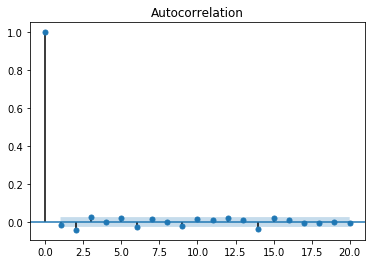

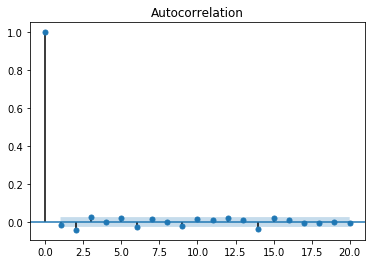

In [84]:
plot_acf(time_bar_returns, lags=20)

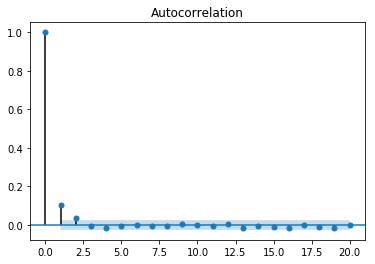

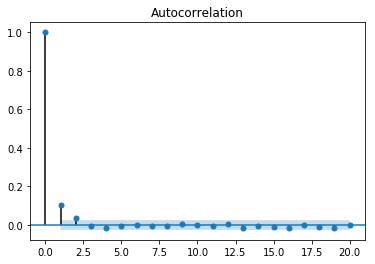

In [85]:
plot_acf(tick_bar_returns, lags=20)

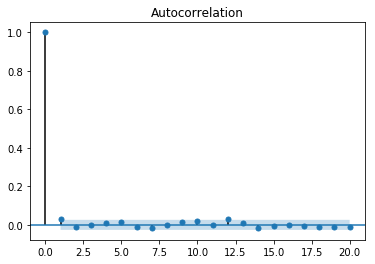

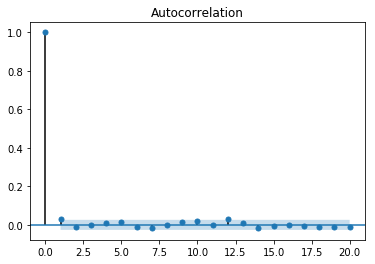

In [87]:
plot_acf(bitcoin_bars_returns, lags=20)

In [ ]:
plot_acf(vo_bars_returns, lags=20)